### Hugging Face

##### Loading Datasets

In [5]:
from datasets import list_datasets

In [6]:
all_datasets = list_datasets()

/var/folders/x4/42m9dxbd6nlgb4j8x_gnynzw0000gp/T/ipykernel_1315/374882858.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


In [8]:
print(f"Number of datasets available: {len(all_datasets)}")

Number of datasets available: 173894


In [9]:
all_datasets[:10]

['amirveyseh/acronym_identification',
 'ade-benchmark-corpus/ade_corpus_v2',
 'UCLNLP/adversarial_qa',
 'Yale-LILY/aeslc',
 'nwu-ctext/afrikaans_ner_corpus',
 'fancyzhx/ag_news',
 'allenai/ai2_arc',
 'google/air_dialogue',
 'komari6/ajgt_twitter_ar',
 'legacy-datasets/allegro_reviews']

In [10]:
from datasets import load_dataset

In [11]:
emotion_dataset = load_dataset("emotion")

Dataset are implemented as Apache Arrow objects inside HuggingFace and can be used with List related operations

In [12]:
len(emotion_dataset),emotion_dataset

(3,
 DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 16000
     })
     validation: Dataset({
         features: ['text', 'label'],
         num_rows: 2000
     })
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 2000
     })
 }))

In [13]:
train_ds = emotion_dataset["train"]

In [14]:
train_ds.column_names

['text', 'label']

To learn the data type of the features inside the dataset

In [15]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [16]:
train_ds[:5]["text"]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

- Basically using the list related operations we can use the Dataset objects in Huggingface

To load the dataset from local files

load_dataset("csv", data_files="file.csv", sep=";", names=["text", "label"])

- From dataset to dataframe

In [17]:
import pandas as pd

In [18]:
emotion_dataset.set_format(type="pandas")

In [19]:
train_df = emotion_dataset["train"][:]

In [20]:
train_df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


We can also get the labels from the integer using int2str()

In [21]:
def label_int2str(row):
    return emotion_dataset["train"].features["label"].int2str(row)

In [22]:
train_df["label_name"] = train_df["label"].apply(label_int2str)

In [23]:
train_df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [24]:
import matplotlib.pyplot as plt

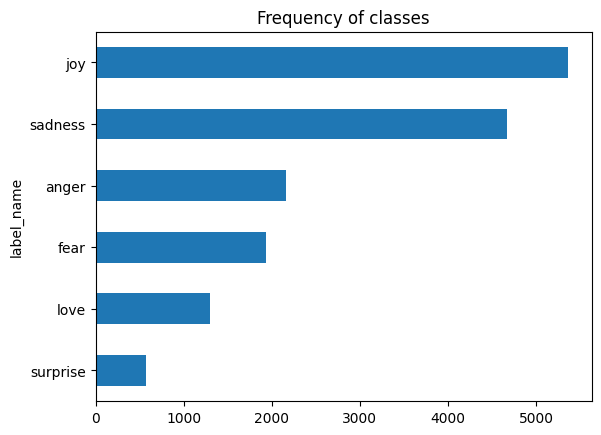

In [25]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

In [26]:
train_df["words per tweet"] = train_df["text"].str.split().apply(len)

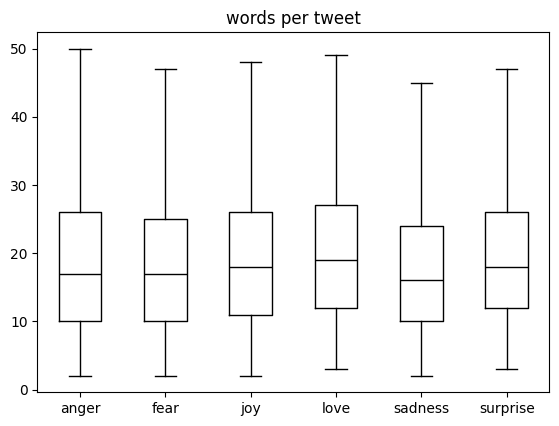

In [27]:
train_df.boxplot("words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [28]:
emotion_dataset.reset_format()

### Tokenization

#### Char Tokenization 

In [29]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [30]:
token2idx = { ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [31]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


These tokens input ids are then converted into One-hot encodings called token encodings, token encodings are transformed to token embeddings

In [32]:
import torch 
import torch.nn.functional as F

In [33]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

In [34]:
one_hot_encodings.shape

torch.Size([38, 20])

In [35]:
tokenized_text[0],input_ids[0], one_hot_encodings[0]

('T',
 tensor(5),
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

The problem with character tokenization is that, we need more compute, memory and power to train models, because first the model would require to learn the words from the character and then learn the word structure, such a training algorithm becomes complex because in character tokenization the text loses its structure

### Word Tokenization

- This way the model skip the step to learn words from characters and reduces the complexity of the training process

In [36]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Problem:
- Words like `NLP.` will make our vocabulary grow exponentially, when we use words there are not just words, but different combinations of words along with punctuation, declination, and misspellings increase the vocabulary of any language to millions.
- If the vocabulary has M word and the first layer of LLM transform the One-hot input vector to 1K dimensional vector, then the first layer itself will have 1M*1K weights = 1B which is crazy, that's why using word tokenization is also not the best way
- Things to do: Stemming, lemmatization, for example great for great, greater, greatest but this lead to lose of contextual information
- Another approach is to discard those words and put them as "UNKNOWN"

### Sub-word tokenization
- Token the words in the following ways:
    - More rare and complex words are tokenized into simple units
    - While Frequent common words are used a single entities

In [37]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

In [38]:
model_ckpt= "distilbert-base-uncased"

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/Users/adityarawat/Desktop/side_projects/ML-System-Design/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [41]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [42]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [43]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokenizer.convert_ids_to_tokens(encoded_text.input_ids))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


- Shows how text was tokenized
- CLS and SEP token represent start and end of a sequence

In [44]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp . [SEP]'

In [45]:
tokenizer.vocab_size

30522

In [46]:
tokenizer.model_max_length

512

In [47]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the whole dataset

In [48]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

The encodings are padded with zero so all the data points (input_id vector) in the dataset have the same size equal to the longest text sequence in the dataset.
Attention mask provides the model information to know where the input vector is padded with zeroes and ignore such padded areas.

In [49]:
emotion_encoded = emotion_dataset.map(tokenize, batched=True, batch_size= None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

map() function generally goes one by one but batched=True applies it on the batch

In [50]:
emotion_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Training a text classifier

### Using features extracted from the Bert model (Transformer as feature extractor)
- These encodings are then converted into embeddings which are the low dimensional space representations and then feed into an Encoder block which produces a hidden state corresponding to each input token in the text
- These hidden state can be used to train a single layer neural network or a random forest

In [51]:
from transformers import AutoModel
import torch

In [53]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("mps")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [54]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(inputs["input_ids"].size())

torch.Size([1, 6])


In [55]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [56]:
inputs= {k:v.to(device) for k,v in inputs.items()}

In [57]:
with torch.no_grad():
    outputs = model(**inputs)

In [58]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='mps:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='mps:0')}

In [59]:
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='mps:0'), hidden_states=None, attentions=None)


In [60]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

It means the test is broken into 6 token and each token as 6 hidden states, each of size 768 Dimensional vector

In [61]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now create a function for the whole dataset

In [62]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

- Here for each sentence we are using the hidden state of [CLS] 

In [63]:
emotion_encoded.set_format("torch", columns=["input_ids", "label","attention_mask"])

In [64]:
emotion_hidden_state = emotion_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [65]:
emotion_hidden_state["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [66]:
import numpy as np

In [67]:
X_train = np.array(emotion_hidden_state["train"]["hidden_state"])
X_valid = np.array(emotion_hidden_state["validation"]["hidden_state"])
y_train = np.array(emotion_hidden_state["train"]["label"])
y_valid = np.array(emotion_hidden_state["validation"]["label"])
X_train.shape, X_valid.shape


((16000, 768), (2000, 768))

### Visualization 

Uniform Manifold Approximation and Projection for Dimension Reducition

In [68]:
import umap.umap_ as umap

from sklearn.preprocessing import MinMaxScaler

In [69]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [70]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.918756,6.543511,0
1,-3.390295,5.881955,0
2,5.349494,3.167455,3
3,-2.715223,3.969468,2
4,-3.654701,3.983688,3


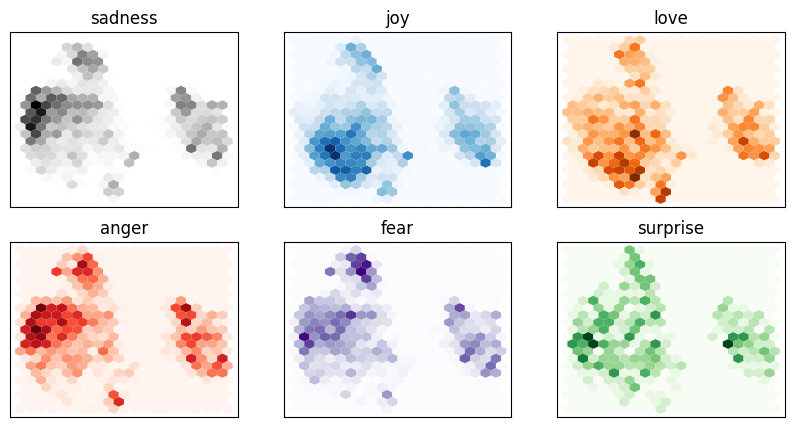

In [71]:
fig, axes = plt.subplots(2,3, figsize=(10,5))
axes= axes.flatten()
cmaps=["Greys", "Blues","Oranges", "Reds", "Purples", "Greens"]
labels = emotion_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub =df_emb.query(f"label== {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

Even though there are overlapping boundaries, the data is only a 2D representation of the original data, if there is not a clear boundary in 2-D dimension doesn't mean there is not clear boundy in 768 dimensional plane. If boundary is clear in 2-D plane, then boundaries are definitely clear in higher Dimensions

In [72]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [73]:
lr_clf.score(X_valid, y_valid)

0.635

In [74]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [76]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

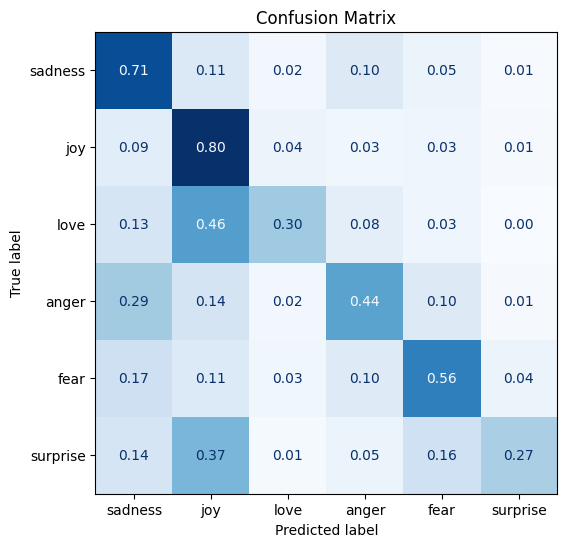

In [77]:
y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine tuning transformer

Tune not just the classification but the entire model parameter and the classification head

In [78]:
from transformers import AutoModelForSequenceClassification

In [79]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy":acc}

In [80]:
from huggingface_hub import notebook_login

In [81]:
notebook_login()

In [82]:
from transformers import Trainer, TrainingArguments

In [83]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

/Users/adityarawat/Desktop/side_projects/ML-System-Design/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
batch_size = 64
logging_steps = len(emotion_encoded["train"]) // batch_size

In [ ]:

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

In [91]:
model_name = f"{model_ckpt}-finetuned_emotionless"
training_args= TrainingArguments(
    output_dir=model_name,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
     num_train_epochs=2,
     learning_rate=2e-5,
     per_device_train_batch_size=batch_size,
     per_device_eval_batch_size=batch_size,
     weight_decay=0.01,   
     disable_tqdm=False,
     logging_steps=logging_steps,
     push_to_hub=True,
     log_level="error")

In [92]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotion_encoded["train"],
    eval_dataset=emotion_encoded["validation"],
    tokenizer=tokenizer
)

In [93]:
trainer.train();

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.261700,0.191890,0.927965,0.927500
2,0.148700,0.161337,0.935357,0.935000


In [95]:
preds_output = trainer.predict(emotion_encoded["validation"])

In [96]:
preds_output.metrics

{'test_loss': 0.1613367348909378,
 'test_f1': 0.9353567216170068,
 'test_accuracy': 0.935,
 'test_runtime': 6.9857,
 'test_samples_per_second': 286.3,
 'test_steps_per_second': 4.581}

In [97]:
y_preds = np.argmax(preds_output.predictions, axis=1)

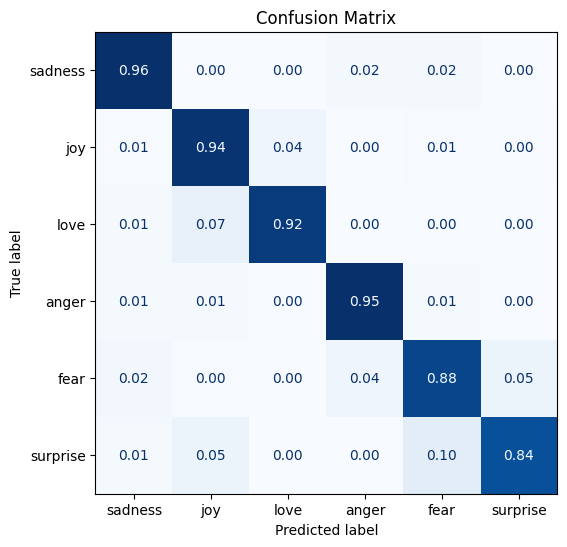

In [98]:
plot_confusion_matrix(y_preds, y_valid, labels)


In [99]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [102]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotion_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotion_encoded["validation"] = emotion_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [104]:
emotion_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotion_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [105]:
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.679293
1801,i feel that he was being overshadowed by the s...,love,sadness,5.904758
1963,i called myself pro life and voted for perry w...,joy,sadness,5.889747
1950,i as representative of everything thats wrong ...,surprise,sadness,5.800426
882,i feel badly about reneging on my commitment t...,love,sadness,5.571959
1509,i guess this is a memoir so it feels like that...,joy,fear,5.552258
1274,i am going to several holiday parties and i ca...,joy,sadness,5.464882
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.107903
1836,i got a very nasty electrical shock when i was...,fear,anger,4.895266
1840,id let you kill it now but as a matter of fact...,joy,fear,4.779721


In [106]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.003470
845,i already feel very glamorous have a great day...,joy,joy,0.003628
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.003641
1137,i think i may be feeling sociable,joy,joy,0.003698
934,i feel a positive responsibility to see this t...,joy,joy,0.003715
1154,i love feeling carefree and without all these ...,joy,joy,0.003722
723,i was able to go to a st party i am back feeli...,joy,joy,0.003724
804,i feel are most valuable i think he discounts ...,joy,joy,0.003738
1688,i feel very very rich and fulfilled and a part...,joy,joy,0.003741
491,i feel like it is a valuable addition to any t...,joy,joy,0.003774


In [107]:
trainer.push_to_hub("First model!")

CommitInfo(commit_url='https://huggingface.co/addie11/distilbert-base-uncased-finetuned_emotionless/commit/d7889e08050973ad5772e1153445e46a1fc36a1f', commit_message='First model!', commit_description='', oid='d7889e08050973ad5772e1153445e46a1fc36a1f', pr_url=None, pr_revision=None, pr_num=None)

In [108]:
from transformers import pipeline

In [109]:
model_id = "addie11/distilbert-base-uncased-finetuned_emotionless"

In [110]:
classifier = pipeline("text-classification", model=model_id)

/Users/adityarawat/Desktop/side_projects/ML-System-Design/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [111]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/Users/adityarawat/Desktop/side_projects/ML-System-Design/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


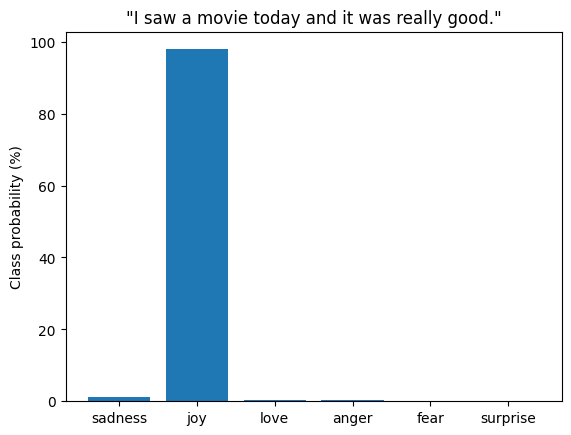

In [112]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()